# Evaluation of the ShNeRF Render results
This Notebook is seperated from the actual Pipeline and has the purpose to measure the exact performance of the imodel


**Prequesits to run this notebook**

In this Notebook, the two "best" checkpoints ``2024-07-28_174845_l1_pure_hook`` and ``2024-07-28_164939_l1_oSig_hook`` were used. Therefore, these are required, as well as the binarized dataset

### Step 1: Render images from the Model Checkpoint using dataset camera positions

``ns-render dataset --load-config outputs\hook\alex-silhouette-model\2024-07-27_221252_l1_oSig_hook\config.yml --rendered-output-names bw --split val --data data\working\binarized_images_lowres\hook --output-path ..\evals-for-doc\2024-07-27_221252_l1_oSig_hook --colormap-options.colormap gray``

``ns-render dataset --load-config outputs\hook\alex-silhouette-model\2024-07-27_172756_l1_pure_hook\config.yml --rendered-output-names bw --split val --data data\working\binarized_images_lowres\hook --output-path ..\evals-for-doc\2024-07-27_172756_l1_pure_hook --colormap-options.colormap gray``

### Step 2: Create IoU's

In [8]:
# Replace these paths with your local paths
images_gt_path = 'C:/dev/TU/htcv-project/nerf-shape-from-silhouette/data/working/binarized_images_lowres/hook/val'

images_pred_path_l1_pure = 'C:/dev/TU/htcv-project/evals-for-doc/2024-07-27_172756_l1_pure_hook/val/bw'
images_pred_path_l1_oSig = 'C:/dev/TU/htcv-project/evals-for-doc/2024-07-27_221252_l1_oSig_hook/val/bw'

# For the IoU visualization
output_folder_pure = 'C:/dev/TU/htcv-project/evals-for-doc/2024-07-27_172756_l1_pure_hook/val/iou'
output_folder_oSig = 'C:/dev/TU/htcv-project/evals-for-doc/2024-07-27_221252_l1_oSig_hook/val/iou'

In [9]:
import os
import cv2
from sklearn.metrics import jaccard_score
import numpy as np

def compute_iou(image1, image2):
    # Flatten the images and compute the IoU
    image1_flat = image1.flatten()
    image2_flat = image2.flatten()
    iou = jaccard_score(image1_flat, image2_flat, average='macro')
    return iou

def binarize_image(image, threshold=50):
    _, binary_image = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)
    return binary_image

def create_overlay(image1, image2):
    # Create an RGB image for visualization
    overlay = np.zeros((image1.shape[0], image1.shape[1], 3), dtype=np.uint8)

    # Intersection in green
    intersection = np.logical_and(image1, image2)
    overlay[intersection == 1] = [255, 255, 255]

    # Differences in red and blue
    only_image1 = np.logical_and(image1, np.logical_not(image2))
    only_image2 = np.logical_and(image2, np.logical_not(image1))

    overlay[only_image1 == 1] = [0, 0, 255]  # The predicted image
    overlay[only_image2 == 1] = [255, 0, 0]  # The ground truth image

    return overlay

def compare_folders(folder1, folder2, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    folder1_images = sorted(os.listdir(folder1))
    folder2_images = sorted(os.listdir(folder2))
    
    if len(folder1_images) != len(folder2_images):
        raise ValueError("The number of images in the two folders should be the same")

    total_iou = 0
    n_images = len(folder1_images)
    
    all_ious = []
    
    for img_name1, img_name2 in zip(folder1_images, folder2_images):
        img1_path = os.path.join(folder1, img_name1)
        img2_path = os.path.join(folder2, img_name2)

        img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
        img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)

        if img1.shape != img2.shape:
            raise ValueError(f"Image sizes do not match: {img_name1} and {img_name2}")

        img1_binary = binarize_image(img1)
        img2_binary = binarize_image(img2)

        iou = compute_iou(img1_binary, img2_binary)
        total_iou += iou

        overlay = create_overlay(img1_binary, img2_binary)
        overlay_path = os.path.join(output_folder, f"{img_name1}_overlay.png")
        cv2.imwrite(overlay_path, overlay)
        
        all_ious.append(iou)
        
    print("saved all IoU Images to " + output_folder)
    average_iou = total_iou / n_images

    with open(os.path.join(output_folder, 'average_iou.txt'), 'w') as f:
        f.write(f"Average IoU for all images: {average_iou:.4f}")

    print(f"Average IoU for all images: {average_iou:.4f}")
    
    return all_ious

In [11]:
# RUN
print("L1 pure: ")
ious_l1_pure = compare_folders(images_gt_path, images_pred_path_l1_pure, output_folder_pure)
print("-")
print("L1 oSig: ")
ious_l1_osig = compare_folders(images_gt_path, images_pred_path_l1_oSig, output_folder_oSig)

L1 pure: 
saved all IoU Images to C:/dev/TU/htcv-project/evals-for-doc/2024-07-27_172756_l1_pure_hook/val/iou
Average IoU for all images: 0.8271
-
L1 oSig: 
saved all IoU Images to C:/dev/TU/htcv-project/evals-for-doc/2024-07-27_221252_l1_oSig_hook/val/iou
Average IoU for all images: 0.8386


### Result Evaluation / Visualization

In [12]:
import matplotlib.pyplot as plt

def plot_overlays(output_folder, title):
    # Get the list of overlay images in the output folder
    overlay_images = sorted([img for img in os.listdir(output_folder) if img.endswith('_overlay.png')])

    # Ensure there are at least 6 images to plot
    if len(overlay_images) < 4:
        raise ValueError('Not enough overlay images to plot. At least 6 required.')

    # Create a figure with 2 rows and 3 columns
    fig, axes = plt.subplots(2, 2, figsize=(8, 8))
    fig.suptitle(title, fontsize=15)

    for i, ax in enumerate(axes.flat):
        # Read the image
        img_path = os.path.join(output_folder, overlay_images[i])
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

        # Display the image
        ax.imshow(img_rgb)
        ax.set_title(overlay_images[i])
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    
def scatter_both_models(pure_ious, osig_ious):
    # Create a box plot
    plt.figure(figsize=(6, 5))
    
    data = [pure_ious, osig_ious]
    
    plt.boxplot(data,
                labels=['L1 Pure', 'L1 oSig'],
                patch_artist=True, 
                boxprops=dict(facecolor='orange',
                    color='black',
                    alpha=0.5),
                whiskerprops=dict(color='black', alpha=1.0),
                medianprops=dict(color='black', alpha=0.0)) # dont show
    
    mean_pure = np.mean(pure_ious)
    mean_osig = np.mean(osig_ious)

    # Overlay individual data points
    for i, dataset in enumerate(data):
        plt.scatter([i + 1] * len(dataset), dataset, color='black', label='All IoUs' if i == 0 else "")
    
    #and mean
    plt.scatter([1], [mean_pure], color='green', edgecolor='black', s=100, zorder=5, label=f'Mean L1 Pure: {mean_pure:.4f}')
    plt.scatter([2], [mean_osig], color='purple', edgecolor='black', s=100, zorder=5, label=f'Mean L1 oSig: {mean_osig:.4f}')
    
    plt.xlim(0.5, 2.5) 
    
    plt.title('IoU Values of L1 Pure and L1 oSig')
    plt.xlabel('Class')
    plt.ylabel('Value')
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles=handles, labels=labels, loc='best')

    
    # Render the plot
    plt.show()

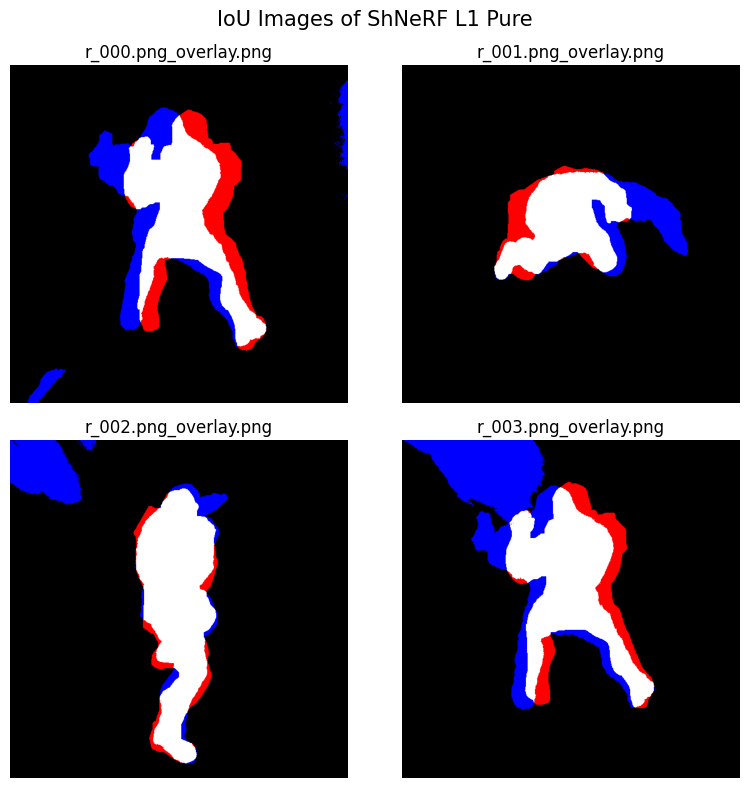

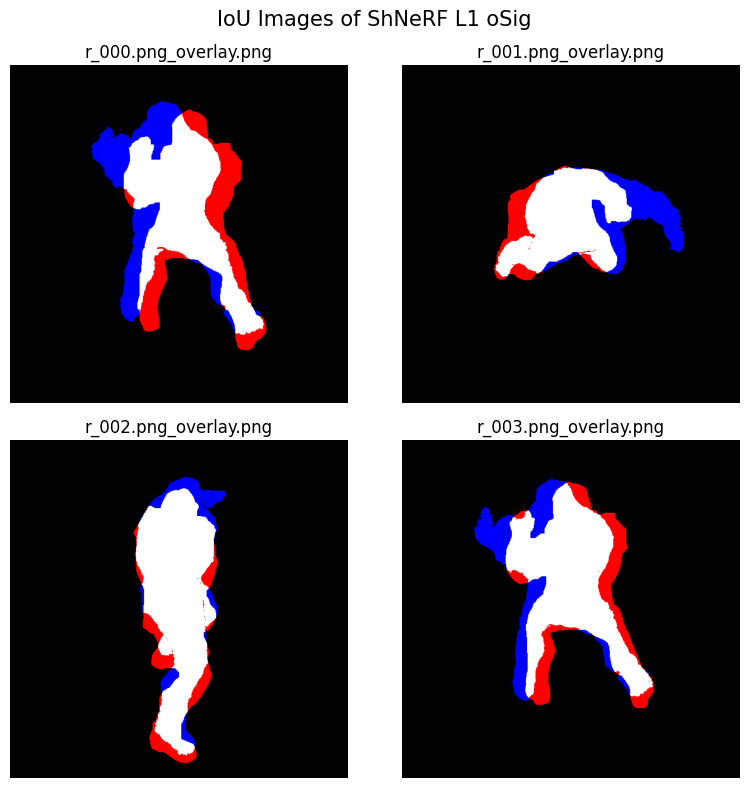

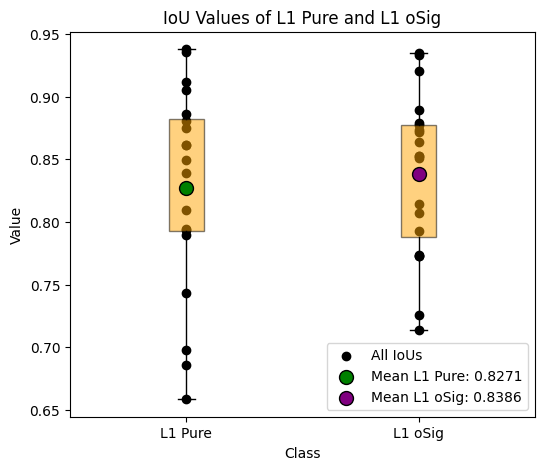

In [13]:
# Show IoU Images
plot_overlays(output_folder_pure, 'IoU Images of ShNeRF L1 Pure')
plot_overlays(output_folder_oSig, 'IoU Images of ShNeRF L1 oSig')

# Show a Scatter Plot of all individual IoU values for oSig and Pure
scatter_both_models(ious_l1_pure, ious_l1_osig)